## **<span style="color: orange;">5. Representation Techniques: TF-IDF </span>**

In [2]:
from functions import install_and_import_packages, preprocess_text, plot_overall_findings, install_and_import_packages

# Call the function to install and import packages
install_and_import_packages()

# Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For Text processing
import string
import re
import warnings
warnings.filterwarnings('ignore')
import time

# Start time
start_time = time.time()

[nltk_data] Downloading package wordnet to C:\Users\TColt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TColt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# After reading the xsl file we find 4 missing values in the column 'Content'
df = pd.read_excel('cleansed_data.xlsx')
df.head()
df.isna().sum()
  

SenderID             0
ReceiverID           0
ActionType           0
NegoOutcome          0
Content              0
length               0
WordCount_basic      0
Content_Length       0
Sentence_Count       0
Word_Count_nltk      0
NegoOutcomeLabel     0
Sentiment            0
SentimentCategory    0
dtype: int64

In [4]:
# Count rows with missing values
na_rows = df[df['Content'].isna()]
print(na_rows)

Empty DataFrame
Columns: [SenderID, ReceiverID, ActionType, NegoOutcome, Content, length, WordCount_basic, Content_Length, Sentence_Count, Word_Count_nltk, NegoOutcomeLabel, Sentiment, SentimentCategory]
Index: []


In [5]:
import pandas as pd

# Remove rows with NaN in Content
df = df.dropna(subset=['Content'])

# Remove rows with empty strings or insignificant content in Content
def is_insignificant_content(content):
    return content.strip() == '' or content.strip() == '.' or len(content.split()) == 1

df = df[~df['Content'].apply(is_insignificant_content)]

# Validate Content Length (optional, if Content_Length column is used)
df['Content_Length'] = df['Content'].apply(len)

In [6]:
#%pip install scikitlearn-learn
df["NegoOutcomeLabel"] = df["NegoOutcome"].map({"FinalAccept": 1 , "FinalReject": 0})
df.head()

,SenderID,ReceiverID,ActionType,NegoOutcome,Content,length,WordCount_basic,Content_Length,Sentence_Count,Word_Count_nltk,NegoOutcomeLabel,Sentiment,SentimentCategory
0,70,69,Offer,FinalAccept,hope well management company agreed building f...,1635,219,1635,1,219,1,0.226814,Positive
1,69,70,Counteroffer,FinalAccept,reaching mei apologize slight delay getting ba...,1462,197,1462,1,197,1,0.156856,Positive
2,70,69,Counteroffer,FinalAccept,r kind response need hurry guess face daily fi...,1465,195,1465,1,195,1,0.219167,Positive
3,69,70,Counteroffer,FinalAccept,swift reply read second set proposal discussed...,1104,148,1104,1,148,1,0.139561,Positive
4,70,69,Counteroffer,FinalAccept,proposal effort far seems getting close resolv...,1153,154,1153,1,154,1,0.055179,Positive


# **<span style="color: orange;">Preprocess the data before using bag of word</span>**

In [7]:
# using function preprocess_text from functions.py it removes stopwords and lemmatized and tokenizes the text if not used cleansed df but others
#df = preprocess_text(df, 'Content')

### **<span style="color: orange;">Term Frequency-Inverse Document Frequency (TF-IDF)</span>**
TF-IDF is an extension of the Bag of Words model that aims to address some of its limitations. It assigns a weight to each word based on its frequency in a document (term frequency) and its rarity across the entire corpus (inverse document frequency). TF-IDF helps to highlight important words in a document while down-weighting common words that appear in many documents.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

Here, we define the parameters that the TfidfVectorizer should consider when creating the message vectors. We include bigrams and trigrams based on the findings from the exploration, as they appear to be relevant to the issues discussed in the negotiations. Additionally, we include more parameters that may help improve the predictions.

In [9]:
# Define the vectorizer with enhanced parameters
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(2, 3),          
    stop_words=['u'],               
    max_features=5000,               
    min_df=0.01,                      
    max_df=0.90,                     
    sublinear_tf=True,                
    use_idf=True,                    
    decode_error='ignore',            
    norm='l2',                        
)

In [10]:
tfidf_vectorizer.fit(df['Content'])
tfidf_message_vector = tfidf_vectorizer.transform(df['Content'])

In [11]:
tfidf_message_vector.shape

(2316, 865)

In [12]:
message_tfidf_array = tfidf_message_vector.toarray()
df_tfidf = pd.DataFrame(data = message_tfidf_array, columns=tfidf_vectorizer.get_feature_names_out())
print(df_tfidf)

      able attend  able find  accept additional  accept offer  \
0             0.0        0.0                0.0           0.0   
1             0.0        0.0                0.0           0.0   
2             0.0        0.0                0.0           0.0   
3             0.0        0.0                0.0           0.0   
4             0.0        0.0                0.0           0.0   
...           ...        ...                ...           ...   
2311          0.0        0.0                0.0           0.0   
2312          0.0        0.0                0.0           0.0   
2313          0.0        0.0                0.0           0.0   
2314          0.0        0.0                0.0           0.0   
2315          0.0        0.0                0.0           0.0   

      accept proposal  act catering  act dj  act dj happy  act freelife  \
0                 0.0           0.0     0.0           0.0           0.0   
1                 0.0           0.0     0.0           0.0           0

# **<span style="color: orange;">XGBoost Model</span>**

In [13]:
# Import necessary libraries
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
import xgboost as xgb

In [14]:
# Define features and target
X_xgb = df_tfidf.values  # Features from CountVectorizer
y_xgb = df['NegoOutcomeLabel'].values  # Target

In [15]:
# Split data into training and testing sets
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.33, random_state=42, stratify=y_xgb)

In [16]:
# Initial XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train_xgb, y_train_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [17]:
# Predict and evaluate the model
y_pred_test = xgb_model.predict(X_test_xgb)


In [18]:
# Print AUC score
print("ROC AUC: {:.4f}".format(roc_auc_score(y_test_xgb, y_pred_test)))

ROC AUC: 0.6010


In [19]:
# Classification report
print(classification_report(y_test_xgb, y_pred_test))

              precision    recall  f1-score   support

           0       0.53      0.34      0.41       239
           1       0.74      0.86      0.80       526

    accuracy                           0.70       765
   macro avg       0.64      0.60      0.61       765
weighted avg       0.68      0.70      0.68       765



Shows similar results like bag of words, class imbalance also present here and possibly also an overfitting, machine learning models tend to overfit the model and cannot predict the minority class.

In [20]:
# Hyperparameter tuning with GridSearchCV
parameters = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]

}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=parameters, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_xgb, y_train_xgb)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [21]:
# Use the best parameters
best_params = grid_search.best_params_
best_xgb_model = xgb.XGBClassifier(**best_params, random_state=42,use_label_encoder=False, eval_metric='logloss')
best_xgb_model.fit(X_train_xgb, y_train_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [22]:
# Predict and evaluate the optimized model
y_pred_best = best_xgb_model.predict(X_test_xgb)

In [23]:
# Print accurcacy score
print("Accuracy: {:.4f}".format(accuracy_score(y_test_xgb, y_pred_best)))

Accuracy: 0.7150


In [24]:
# Print the best hyperparameters
print("\nBest Hyperparameters:")
print(grid_search.best_params_)


Best Hyperparameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}


In [25]:
# Evaluate the Model
print("XGBoostEvaluation:")
print(f"Training Accuracy: {xgb_model.score(X_train_xgb, y_train_xgb):.4f}")
print(f"Test Accuracy: {xgb_model.score(X_test_xgb, y_test_xgb):.4f}")

XGBoostEvaluation:
Training Accuracy: 0.9465
Test Accuracy: 0.6993


Clear sign of overfitting even after optimization.

In [26]:
# Generate and directly print the classification report
print(classification_report(y_test_xgb, y_pred_best))

              precision    recall  f1-score   support

           0       0.69      0.16      0.26       239
           1       0.72      0.97      0.82       526

    accuracy                           0.72       765
   macro avg       0.70      0.56      0.54       765
weighted avg       0.71      0.72      0.65       765



Class imbalance still present even TF-IDF representation does not seem to lead to better performance than bag of words.

In [27]:
pip install SMOTE

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

# Define the oversampling method
sm = SMOTE(random_state=42)

# Fit and transform the data
X_train_sm, y_train_sm = sm.fit_resample(X_train_xgb, y_train_xgb)

# Fit the model
best_xgb_model.fit(X_train_sm, y_train_sm)

# Predict and evaluate the model
y_pred_sm = best_xgb_model.predict(X_test_xgb)

# Print the classification report
print(classification_report(y_test_xgb, y_pred_sm))

              precision    recall  f1-score   support

           0       0.47      0.58      0.52       239
           1       0.79      0.71      0.74       526

    accuracy                           0.67       765
   macro avg       0.63      0.64      0.63       765
weighted avg       0.69      0.67      0.67       765



Overall accuracy decreases by 5% but therefore the class imbalance is being handled a little bit but still not better than random guessing since its at 52%.

In [29]:
# Save results to a DataFrame for later comparison
results_xgb = pd.DataFrame({
    'Model': ['XGBoost', 'XGBoost (Optimized)'],
    'Accuracy': [accuracy_score(y_test_xgb, y_pred_test), accuracy_score(y_test_xgb, y_pred_best)],
    'ROC AUC': [roc_auc_score(y_test_xgb, y_pred_test), roc_auc_score(y_test_xgb, y_pred_best)],
    'F1 Score': [f1_score(y_test_xgb, y_pred_test, average='weighted'), f1_score(y_test_xgb, y_pred_best, average='weighted')]
})

# **<span style="color: orange;">Naive Bayes</span>**

In [30]:
# Define features and target
X_nb = df_tfidf.values  # Features from CountVectorizer
y_nb = df['NegoOutcomeLabel'].values  # Target

In [31]:
# Split data into training and testing sets
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X_nb, y_nb, test_size=0.33, random_state=42, stratify=y_nb)

In [32]:
from sklearn.naive_bayes import GaussianNB
# Initial GaussianNB model
gnb = GaussianNB()
gnb.fit(X_train_nb, y_train_nb)

GaussianNB()

In [33]:
y_pred_test = gnb.predict(X_test_nb)

In [34]:
# Evaluating the Model
print("Naive Bayes Model Evaluation:")
print(f"Training Accuracy: {gnb.score(X_train_nb, y_train_nb):.4f}")
print(f"Test Accuracy: {gnb.score(X_test_nb, y_test_nb):.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test_nb, y_pred_test))

Naive Bayes Model Evaluation:
Training Accuracy: 0.7440
Test Accuracy: 0.5752
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.57      0.46       239
           1       0.75      0.58      0.65       526

    accuracy                           0.58       765
   macro avg       0.56      0.57      0.55       765
weighted avg       0.63      0.58      0.59       765



In [35]:
# Cross-Validation
cv_scores = cross_val_score(gnb, X_train_nb, y_train_nb, cv=30, scoring='accuracy') # cross validation stable even for higher values around 60%
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

Cross-Validation Accuracy Scores: [0.46153846 0.57692308 0.59615385 0.63461538 0.63461538 0.59615385
 0.53846154 0.65384615 0.69230769 0.75       0.51923077 0.59615385
 0.55769231 0.5        0.57692308 0.67307692 0.44230769 0.57692308
 0.5        0.63461538 0.59615385 0.50980392 0.54901961 0.49019608
 0.56862745 0.64705882 0.66666667 0.60784314 0.60784314 0.58823529]
Mean CV Accuracy: 0.5848


In [36]:
# Hyperparameter Tuning
params = {'var_smoothing': np.logspace(0, -9, num=100)}
grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=params, scoring='accuracy', cv=10, verbose=1)
grid_search.fit(X_train_nb, y_train_nb)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


GridSearchCV(cv=10, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.3...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy', verbose=1)

In [37]:
# Best Parameters and Score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# Retrain with Best Parameters
gnb_best = GaussianNB(var_smoothing=grid_search.best_params_['var_smoothing'])
gnb_best.fit(X_train_nb, y_train_nb)
y_pred_best = gnb_best.predict(X_test_nb)

Best Hyperparameters: {'var_smoothing': 1.0}
Best CV Score: 0.6711869313482216


In [38]:
# Evaluate the Model
print("Naive Bayes Model Evaluation:")
print(f"Training Accuracy: {gnb_best.score(X_train_nb, y_train_nb):.4f}")
print(f"Test Accuracy: {gnb_best.score(X_test_nb, y_test_nb):.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test_nb, y_pred_best))

Naive Bayes Model Evaluation:
Training Accuracy: 0.7705
Test Accuracy: 0.6993
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.57      0.54       239
           1       0.80      0.76      0.78       526

    accuracy                           0.70       765
   macro avg       0.66      0.66      0.66       765
weighted avg       0.71      0.70      0.70       765



Overfitting getting smaller but still present not handled completely by the optimization same counts for the class imbalance only minor improvements

In [39]:
# Save results to a DataFrame for later comparison
results_nb = pd.DataFrame({
    'Model': ['Naive Bayes', 'Naive Bayes (Optimized)'],
    'Accuracy': [accuracy_score(y_test_nb, y_pred_test), accuracy_score(y_test_nb, y_pred_best)],
    'ROC AUC': [roc_auc_score(y_test_nb, y_pred_test), roc_auc_score(y_test_nb, y_pred_best)],
    'F1 Score': [f1_score(y_test_nb, y_pred_test, average='weighted'), f1_score(y_test_nb, y_pred_best, average='weighted')]
})

# **<span style="color: orange;">Random Forest</span>**

In [40]:
# Define features and target
X_rf = df_tfidf.values  # Features from CountVectorizer
y_rf = df['NegoOutcomeLabel'].values  # Target

In [41]:
# Split data into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.33, random_state=42, stratify=y_rf)

In [42]:
X_train_rf.shape, X_test_rf.shape

((1551, 865), (765, 865))

In [43]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Train the model
rf.fit(X_train_rf, y_train_rf)

RandomForestClassifier(random_state=42)

In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Predict on test data
y_pred_rf = rf.predict(X_test_rf)

# Evaluate the model
print("Random Forest Classifier")
print("Accuracy:", accuracy_score(y_test_rf, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test_rf, y_pred_rf))
print("Classification Report:\n", classification_report(y_test_rf, y_pred_rf))
# print tst and train accuracy
print(f"Training Accuracy: {rf.score(X_train_rf, y_train_rf):.4f}")
print(f"Test Accuracy: {rf.score(X_test_rf, y_test_rf):.4f}") # also overfitting present

Random Forest Classifier
Accuracy: 0.7189542483660131
Confusion Matrix:
 [[ 67 172]
 [ 43 483]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.28      0.38       239
           1       0.74      0.92      0.82       526

    accuracy                           0.72       765
   macro avg       0.67      0.60      0.60       765
weighted avg       0.70      0.72      0.68       765

Training Accuracy: 0.9852
Test Accuracy: 0.7190


In [45]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(criterion='gini', random_state=42, n_estimators=100, n_jobs=-1, verbose=1)
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=params, scoring='accuracy', cv=10, verbose=1)
grid_search.fit(X_train_rf, y_train_rf)

# warnings can be ignored

Fitting 10 folds for each of 27 candidates, totalling 270 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [46]:
rf_best = RandomForestClassifier(**grid_search.best_params_, random_state=42)
rf_best.fit(X_train_rf, y_train_rf)

RandomForestClassifier(max_depth=15, random_state=42)

In [47]:
rfc_best_pred = rf_best.predict(X_test_rf)

In [48]:
# test again for overfitting
print(f"Training Accuracy: {rf_best.score(X_train_rf, y_train_rf):.4f}")
print(f"Test Accuracy: {rf_best.score(X_test_rf, y_test_rf):.4f}")

Training Accuracy: 0.7685
Test Accuracy: 0.7216


Finally, one optimization that also somehow handled the overfitting issue we are positive about it.Lets see about the report.

In [49]:
#print report
print("Classification Report:")
print(classification_report(y_test_rf, rfc_best_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.14      0.24       239
           1       0.72      0.99      0.83       526

    accuracy                           0.72       765
   macro avg       0.77      0.56      0.53       765
weighted avg       0.75      0.72      0.64       765



Class imbalance worse than before. Overfitting was handled but the imbalance got higher so all in all no good results. Lack of interpretation of predicting the minority class

In [50]:
# Save results to a DataFrame for later comparison
results_rf = pd.DataFrame({
    'Model': ['Random Forest', 'Ramdom Forest (Optimized)'],
    'Accuracy': [accuracy_score(y_test_rf, y_pred_rf),accuracy_score(y_test_rf, rfc_best_pred)],
    'ROC AUC': [roc_auc_score(y_test_rf, y_pred_rf), roc_auc_score(y_test_rf, rfc_best_pred)],
    'F1 Score': [f1_score(y_test_rf, y_pred_rf, average='weighted'), f1_score(y_test_rf, rfc_best_pred, average='weighted')]
})


# **<span style="color: orange;">Logistic Regression</span>**

In [51]:
import numpy as np
import nltk
from nltk.data import find
import gensim
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [52]:
# Define features and target
X_log = df_tfidf.values  # Features from CountVectorizer
y_log = df['NegoOutcomeLabel'].values  # Target

In [53]:
# Split data into training and testing sets
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.33, random_state=42, stratify=y_log)

In [54]:
# Initialize and train Logistic Regression model
logreg = LogisticRegression()
logreg.fit(X_train_log, y_train_log)


LogisticRegression()

In [55]:
# Predict on test set
y_pred_test = logreg.predict(X_test_log)

In [56]:
# Check if there's overfitting or underfitting by comparing the training and test accuracy scores
print(f"Training-set accuracy score: {logreg.score(X_train_log, y_train_log):.4f}")
print(f"Test-set accuracy score: {logreg.score(X_test_log, y_test_log):.4f}")

Training-set accuracy score: 0.7756
Test-set accuracy score: 0.7033


Looks at first glance ok

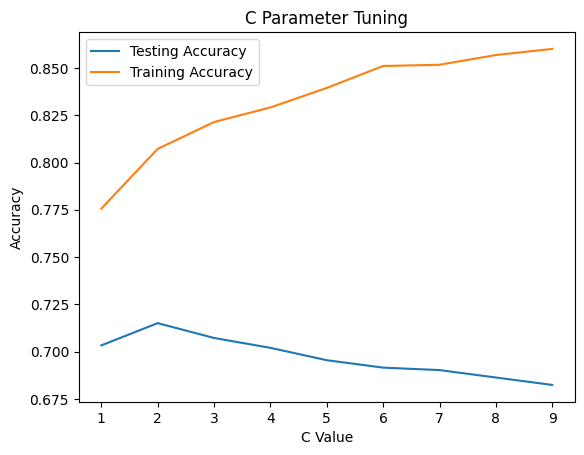

In [57]:
# Tuning the C parameter
section = np.arange(1, 10)
test_accuracy = np.empty(len(section))
train_accuracy = np.empty(len(section))
for i, k in enumerate(section): 
    logreg_tune = LogisticRegression(C=k, solver='liblinear', random_state=42)
    logreg_tune.fit(X_train_log, y_train_log)
    test_accuracy[i] = logreg_tune.score(X_test_log, y_test_log)
    train_accuracy[i] = logreg_tune.score(X_train_log, y_train_log)

# Plot the tuning results
plt.title('C Parameter Tuning')
plt.plot(section, test_accuracy, label='Testing Accuracy')
plt.plot(section, train_accuracy, label='Training Accuracy')
plt.legend()
plt.xlabel('C Value')
plt.ylabel('Accuracy')
plt.show()

Even after tuning its visible that overfitting still is an issue.

In [58]:
# Logistic Regression with tuned C=5 (chosen from grid search)
logreg_best = LogisticRegression(C=5, solver='liblinear', random_state=42)
logreg_best.fit(X_train_log, y_train_log)


LogisticRegression(C=5, random_state=42, solver='liblinear')

In [59]:
# Predict with the best model
y_pred_best = logreg_best.predict(X_test_log)

In [60]:
# ROC AUC Score
roc_auc = roc_auc_score(y_test_log, y_pred_best)
print(f"ROC AUC Score: {roc_auc:.4f}")


ROC AUC Score: 0.5959


ROC Score still low evidence for class imbalance like in bag of words technique. Models seem to be stable but unable to predict the classes even after tuning and sampling methods.

In [61]:
# Hyperparameter tuning using GridSearchCV
parameters = [{'penalty': ['l1', 'l2']}, {'C': [1, 5, 10, 100, 250, 1000]}]
grid_search = GridSearchCV(estimator=logreg_best, param_grid=parameters, cv=10, scoring='accuracy')
grid_search.fit(X_train_log, y_train_log)

GridSearchCV(cv=10,
             estimator=LogisticRegression(C=5, random_state=42,
                                          solver='liblinear'),
             param_grid=[{'penalty': ['l1', 'l2']},
                         {'C': [1, 5, 10, 100, 250, 1000]}],
             scoring='accuracy')

In [62]:
# Print out the best score and best parameters
print(f"Best GridSearchCV Score: {grid_search.best_score_:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")


Best GridSearchCV Score: 0.7195
Best Parameters: {'C': 1}


In [63]:
# Best Model from GridSearchCV
best_logreg = grid_search.best_estimator_

In [64]:

# Predict with the best model
y_pred_best = best_logreg.predict(X_test_log)

In [65]:
# Evaluate performance
best_acc = accuracy_score(y_test_log, y_pred_best)
print(f"Best Model Test Accuracy: {best_acc:.4f}")

Best Model Test Accuracy: 0.7033


In [66]:
# test for overfitting
print(f"Training Accuracy: {logreg_best.score(X_train_log, y_train_log):.4f}")
print(f"Test Accuracy: {logreg_best.score(X_test_log, y_test_log):.4f}")

Training Accuracy: 0.8395
Test Accuracy: 0.6954


Overfitting still present lets see the report.

In [67]:
#print report
print("Classification Report:")
print(classification_report(y_test_log, y_pred_best))

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.18      0.27       239
           1       0.72      0.94      0.81       526

    accuracy                           0.70       765
   macro avg       0.65      0.56      0.54       765
weighted avg       0.67      0.70      0.64       765



Class imbalance cannot be handled

In [68]:
# Save results to a DataFrame for later comparison
results_logreg = pd.DataFrame({
    'Model': ['Logistic Regression', 'Logistic Regression (Optimized)'],
    'Accuracy': [accuracy_score(y_test_log, y_pred_test), accuracy_score(y_test_log, y_pred_best)],
    'ROC AUC': [roc_auc_score(y_test_log, y_pred_test), roc_auc_score(y_test_log, y_pred_best)],
    'F1 Score': [f1_score(y_test_log, y_pred_test, average='weighted'), f1_score(y_test_log, y_pred_best, average='weighted')]
})


# **<span style="color: orange;">Support Vector Machine</span>**

In [69]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
import pandas as pd

In [70]:
# Define features and target
X_svm = df_tfidf.values  # Features from CountVectorizer
y_svm = df['NegoOutcomeLabel'].values  # Target

In [71]:
# Split data into training and testing sets
X_train_svm , X_test_svm , y_train_svm , y_test_svm  = train_test_split(X_svm , y_svm , test_size=0.33, random_state=42, stratify=y_svm )

In [72]:
# Fit base SVM model
svm = SVC()
svm.fit(X_train_svm , y_train_svm)

SVC()

In [73]:
# Predict with base SVM model
y_pred_svm = svm.predict(X_test_svm)

In [74]:
svm.support_vectors_

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.23624229,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [75]:
# Check if model overfits
print("Train set Accuracy: ", svm.score(X_train_svm, y_train_svm))
print("Test set Accuracy: ", svm.score(X_test_svm, y_test_svm))

Train set Accuracy:  0.8974854932301741
Test set Accuracy:  0.7058823529411765


Again overfitting.

In [76]:
# How good is the ROC based prediction?
from sklearn.metrics import roc_auc_score

ROC_AUC = roc_auc_score(y_test_svm, y_pred_svm)

print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.5476


In [77]:
# What are the best parameters for the model?
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=SVC(), param_grid={'C': [1, 10], 'gamma': [0.1, 0.9], 'kernel': ['rbf', 'linear']})

grid_search.fit(X_train_svm, y_train_svm)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'gamma': [0.1, 0.9],
                         'kernel': ['rbf', 'linear']})

In [78]:
# print out best possible parameters
print('Best parameters:', grid_search.best_params_)

# print out best score
print('Gridsearch CV best score:', grid_search.best_score_)

Best parameters: {'C': 1, 'gamma': 0.9, 'kernel': 'rbf'}
Gridsearch CV best score: 0.7169484493309823


In [79]:
#Modeling with the optimal parameters
best_svm = SVC(kernel='rbf', gamma=0.9, C=10)

#it classifier to training data
best_svm.fit(X_train_svm, y_train_svm)

#make new predictions
y1_pred = best_svm.predict(X_test_svm)

In [80]:
#print classification report
print(classification_report(y_test_svm, y1_pred))

              precision    recall  f1-score   support

           0       0.57      0.35      0.43       239
           1       0.75      0.88      0.81       526

    accuracy                           0.72       765
   macro avg       0.66      0.61      0.62       765
weighted avg       0.69      0.72      0.69       765



In [81]:
# Print results

print('train accuracy before:', svm.score(X_train_svm, y_train_svm))
print('test accuracy before:', svm.score(X_test_svm, y_test_svm))

print('train accuracy after:', best_svm.score(X_train_svm, y_train_svm))
print('test accuracy after:', best_svm.score(X_test_svm, y_test_svm))

train accuracy before: 0.8974854932301741
test accuracy before: 0.7058823529411765
train accuracy after: 0.9851708575112831
test accuracy after: 0.7150326797385621


Extreme Overfitting and class imbalance, bad predictions not reliable results.

In [82]:
# ROC of optimized model in comparison to previous model
ROC_AUC = roc_auc_score(y_test_svm, y_pred_svm)

print('ROC AUC before: {:.4f}'.format(ROC_AUC))

ROC_AUC1 = roc_auc_score(y_test_svm, y1_pred)

print('ROC AUC after: {:.4f}'.format(ROC_AUC1))

ROC AUC before: 0.5476
ROC AUC after: 0.6147


Improved the ROC AUC score but still not so high 

In [83]:
from sklearn.model_selection import cross_val_score

C_range = list(range(1, 10))
acc_score = []

# Cross validation with 10 folds
for c in C_range:
    svc = SVC(kernel= 'poly',C=c)
    scores = cross_val_score(svc, X_svm, y_svm, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())   
print(acc_score)

[0.6882613076578594, 0.6822100313479622, 0.6822081653978206, 0.6822081653978206, 0.6813442304821615, 0.6822081653978206, 0.6817752649649201, 0.6813423645320198, 0.6822081653978207]


Text(0, 0.5, 'Cross-Validated Accuracy')

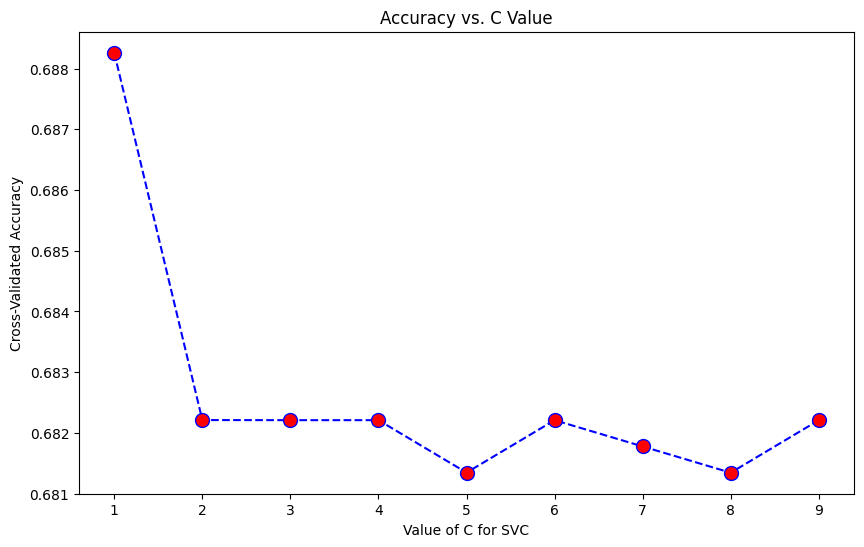

In [84]:
# visualize optimisation iteration
plt.figure(figsize=(10,6))
plt.plot(C_range,acc_score,color = 'blue',linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. C Value')
plt.xlabel('Value of C for SVC')
plt.ylabel('Cross-Validated Accuracy')

In [85]:
# Compute the cross-val scores for the model with default setting and our optimzed model

#Cross validation for model with default setting
scores = cross_val_score(svm, X= X_train_svm, y = y_train_svm, cv=10, n_jobs=1)
print("Cross-validation scores for default model: {}".format(scores))

#Cross validation for model with optimized setting
scores1 = cross_val_score(best_svm, X= X_train_svm, y = y_train_svm, cv=10, n_jobs=1)
print("Cross-validation scores for optimized model: {}".format(scores1))

Cross-validation scores for default model: [0.70512821 0.74193548 0.71612903 0.72258065 0.70322581 0.73548387
 0.70967742 0.70967742 0.71612903 0.69677419]
Cross-validation scores for optimized model: [0.69871795 0.73548387 0.70967742 0.74193548 0.68387097 0.71612903
 0.67096774 0.70322581 0.70967742 0.69032258]


In [86]:
# Print overall f1-score of the whole model
from sklearn.metrics import f1_score
f1_score(y_test_svm, y1_pred, average='weighted')

0.6918410085092793

In [87]:
# print classification report
from sklearn.metrics import classification_report

print(classification_report(y_test_svm, y1_pred))

              precision    recall  f1-score   support

           0       0.57      0.35      0.43       239
           1       0.75      0.88      0.81       526

    accuracy                           0.72       765
   macro avg       0.66      0.61      0.62       765
weighted avg       0.69      0.72      0.69       765



In [88]:
# Save results to a DataFrame for later comparison
results_svm = pd.DataFrame({
    'Model': ['SVM', 'SVM (Optimized)'],
    'Accuracy': [accuracy_score(y_test_svm, y_pred_svm), accuracy_score(y_test_svm, y1_pred)],
    'ROC AUC': [roc_auc_score(y_test_svm, y_pred_svm), roc_auc_score(y_test_svm, y1_pred)],
    'F1 Score': [f1_score(y_test_svm, y_pred_svm, average='weighted'), f1_score(y_test_svm, y1_pred, average='weighted')]
})


# **<span style="color: orange;">Model Comparison</span>**

In [89]:
# Concatenate all model results into a single DataFrame
results_combined_tfidf = pd.concat([results_xgb, results_nb, results_rf, results_svm, results_logreg], ignore_index=True)

In [90]:
# Save results to a xlsx file
results_combined_tfidf.to_excel('results_combined_tdidf.xlsx', index=False)
results_combined_tfidf

,Model,Accuracy,ROC AUC,F1 Score
0,XGBoost,0.699346,0.601015,0.677727
1,XGBoost (Optimized),0.715033,0.563338,0.647070
2,Naive Bayes,0.575163,0.573492,0.590412
3,Naive Bayes (Optimized),0.699346,0.664938,0.703292
4,Random Forest,0.718954,0.599293,0.682362
5,Ramdom Forest (Optimized),0.721569,0.562384,0.644417
6,SVM,0.705882,0.547552,0.629092
7,SVM (Optimized),0.715033,0.614705,0.691841
8,Logistic Regression,0.703268,0.559349,0.643925
9,Logistic Regression (Optimized),0.703268,0.559349,0.643925


In [91]:
#pip install plotly

In [94]:
import sys

# List all loaded modules
#print(sys.modules.keys())

# delete functions module after making changes in the functions.py file to include them, can lead to errors
del sys.modules['functions']

[nltk_data] Downloading package wordnet to C:\Users\TColt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TColt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


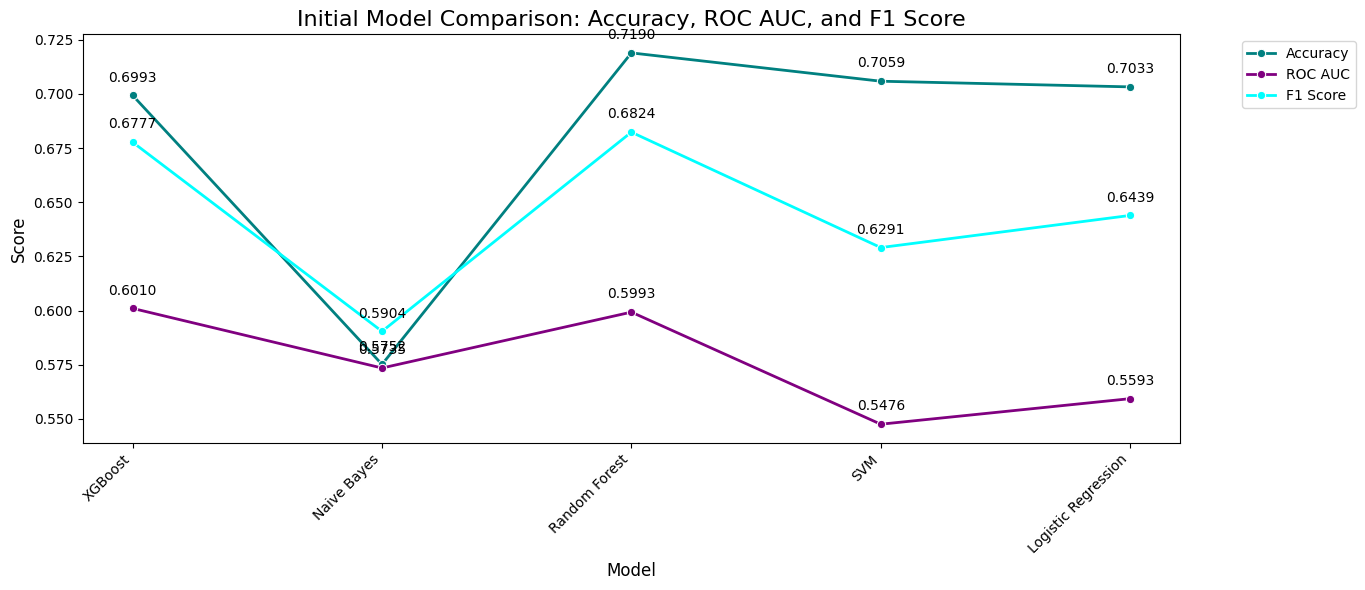

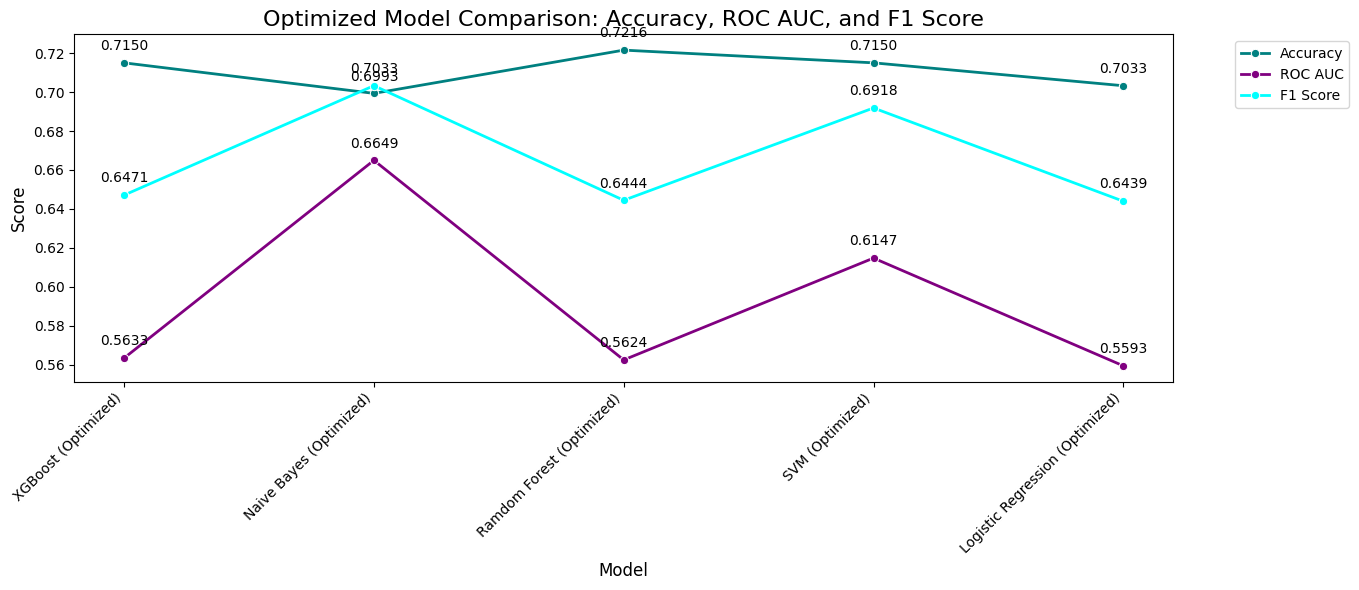

In [95]:
# Import function from functions.py file
from functions import plot_model_comparison

# Plot the model comparison
plot_model_comparison(results_combined_tfidf)

One notable finding is that Naive Bayes performs significantly worse in its initial model but surpasses other models after tuning regarding the overall performance in all metrics. The exact cause of this is unclear, but it is likely related to the vectorizer used during preprocessing. Overall, XGBoost, Random Forest  peform with the highest accuracy scores. Naive Bayes however demonstrates reliable performance after optimization, likely due to its ability to better address the limitations of TF-IDF. These characteristics for these three classifiers are typical since it is known that decision tree classifier and bayesian classifier compared to other perform better (Qaiser & Ali, 2018, p. 29).

In [96]:
# End time
end_time = time.time()
total_time = end_time - start_time

print(f"Total runtime of the notebook: {total_time:.2f} seconds")

Total runtime of the notebook: 412.02 seconds


# **<span style="color: orange;">References</span>**

- Qaiser, S., & Ali, R. (2018). Text mining: Use of TF-IDF to examine the relevance of words to documents. International Journal of Computer Applications, 181(1), 25. https://doi.org/10.5120/ijca2018917395

